In [ ]:
# !pip install shap==0.41.0
# !pip install lightfm==1.16
# !pip install rectools==0.3.0
# !pip install prompt-toolkit==3.0.33

In [ ]:
# !pip install catboost

In [3]:
import warnings
warnings.simplefilter('ignore')

import dill
import numpy as np
import pandas as pd
import requests
import shap

from lightfm import LightFM
from lightfm.data import Dataset
from lightgbm import LGBMRanker, LGBMClassifier
from xgboost import XGBRanker
from catboost import CatBoostRanker, Pool

import rectools
from rectools.metrics import calc_metrics, NDCG, MAP, Precision, Recall, MeanInvUserFreq
from rectools import Columns
from rectools.models import ImplicitALSWrapperModel, PopularModel
from implicit.als import AlternatingLeastSquares

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from typing import Any, Dict, Tuple
from tqdm.auto import tqdm
from zipfile import ZipFile

from tools import generate_lightfm_recs_mapper, avg_user_metric

## Подготовка данных

In [4]:
# download dataset by chunks
url = 'https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip'

req = requests.get(url, stream=True)

PATH_TO_DATA = 'kion_train.zip'

with open(PATH_TO_DATA, 'wb') as f:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        f.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [5]:
with ZipFile('kion_train.zip') as z:
    
    with z.open('kion_train/interactions.csv') as f:
        interactions = pd.read_csv(f)
    
    with z.open('kion_train/items.csv') as f:
        items = pd.read_csv(f)
        
    with z.open('kion_train/users.csv') as f:
        users = pd.read_csv(f)

In [6]:
# Меняем названия колонок для использования rectools
interactions.rename(
    columns={
        'last_watch_dt': Columns.Datetime,
        'watched_pct': Columns.Weight,
    }, 
    inplace=True,
) 

# Меняем тип данных
interactions['datetime'] = interactions['datetime'].astype(np.datetime64)

# Заполняем пропуски
interactions_default_values: Dict[str, Any] = {
   Columns.Datetime: interactions[Columns.Datetime].median(),
    Columns.Weight: 0.,
    'total_dur': 0,
}
interactions.fillna(interactions_default_values, inplace=True)

In [7]:
def encode_cat_cols(df: pd.DataFrame, cat_cols) -> Tuple[pd.DataFrame, Dict]:
    cat_col_encoding = {}  # словарь с категориями

    for col in cat_cols:
        cat_col = df[col].astype('category').cat
        cat_col_encoding[col] = cat_col.categories
        df[col] = cat_col.codes.astype('category')
    return df, cat_col_encoding

users_cat_cols = [
     'age', 'income', 'sex', 'kids_flg'
]
users, users_cat_col_encoding = encode_cat_cols(users, users_cat_cols)

In [8]:
# кодируем категориальные колонки и удаляем текстовые
items_cat_cols = [
    # 'item_id', 
    'content_type', 'for_kids', 'studios',
]
items_text_cols = [
    'title', 'title_orig', 'genres', 'countries', 'directors', 'actors', 'description', 'keywords',
]
items_num_cols = [
    'release_year', 'age_rating', 
]
default_values_items = {
    'release_year': items['release_year'].median(),
    'age_rating': items['age_rating'].median(),
}

items, items_cat_col_encoding = encode_cat_cols(items, items_cat_cols) 
# items = items.drop(items_text_cols, axis=1)
items.fillna(default_values_items, inplace=True)

## Трейн-вал-тест сплит

In [9]:
max_date = interactions[Columns.Datetime].max()
min_date = interactions[Columns.Datetime].min()

print(f'min дата в interactions: {min_date}')
print(f'max дата в interactions: {max_date}')
print(f'Продолжительность: {max_date - min_date}')

min дата в interactions: 2021-03-13 00:00:00
max дата в interactions: 2021-08-22 00:00:00
Продолжительность: 162 days 00:00:00


In [10]:
ranker_days_count = 30

ranker_data = interactions[
    (interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=ranker_days_count))
]

train_size = 0.7
val_size = 0.15
test_size = 0.15 

train_val_users, test_users = train_test_split(
    ranker_data['user_id'].unique(), random_state=42, test_size=test_size
)

train_users, val_users = train_test_split(
    train_val_users, random_state=42, test_size=val_size / (train_size + val_size)  # 15% от общего размера
)

In [11]:
base_models_data = interactions[
    (interactions[Columns.Datetime] < max_date - pd.Timedelta(days=ranker_days_count))
]

In [12]:
users = users.loc[users[Columns.User].isin(base_models_data[Columns.User])].copy()

user_features_frames = []
for feature in ["sex", "age", "income"]:
    feature_frame = users.reindex(columns=[Columns.User, feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    user_features_frames.append(feature_frame)
user_features = pd.concat(user_features_frames)

In [13]:
items = items.loc[items[Columns.Item].isin(base_models_data[Columns.Item])].copy()

items["genre"] = items["genres"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"

content_feature = items.reindex(columns=[Columns.Item, "content_type"])
content_feature.columns = ["id", "value"]
content_feature["feature"] = "content_type"

item_features = pd.concat((genre_feature, content_feature))

In [14]:
dataset = rectools.dataset.Dataset.construct(
    interactions_df=base_models_data,
    user_features_df=user_features,
    cat_user_features=["sex", "age", "income"],
    item_features_df=item_features,
    cat_item_features=["genre", "content_type"],
)

In [15]:
items = items.drop(items_text_cols, axis=1)

## Обучаем модель первого уровня

### LightFM

In [16]:
lightfm_dataset = Dataset()
lightfm_user_ids = base_models_data['user_id'].unique()
lightfm_item_ids = base_models_data['item_id'].unique()
lightfm_dataset.fit(lightfm_user_ids, lightfm_item_ids)

In [17]:
interactions_matrix, weights_matrix = lightfm_dataset.build_interactions(
    zip(*base_models_data[['user_id', 'item_id', Columns.Weight]].values.T)
)
weights_matrix = weights_matrix.tocsr()

In [18]:
lfm_model = LightFM(
    no_components=64, 
    learning_rate=0.1, 

    loss='warp', 
    max_sampled=5, 
    random_state=42,
)

num_epochs = 10

for _ in tqdm(range(num_epochs)):
    lfm_model.fit_partial(weights_matrix)

  0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
# save model  
with open(f'lfm_model.dill', 'wb') as f:
    dill.dump(lfm_model, f)

### Implicit ALS

In [20]:
als_model = ImplicitALSWrapperModel(model=AlternatingLeastSquares(
                                        factors=16,
                                        random_state=42,
                                        num_threads=16,
                                        ),
                                  fit_features_together=True,
                                  )

als_model.fit(dataset)

In [21]:
# save model
with open(f'als_model.dill', 'wb') as f:
    dill.dump(als_model, f)

### Popular (for cold users)

In [22]:
pop_model = PopularModel()
pop_model.fit(dataset)

In [23]:
# save model
with open('pop_model.dill', 'wb') as f:
   dill.dump(pop_model, f)

## Генерим кандидатов, которыми дополним датасет ранкера

In [24]:
lightfm_mapping = lightfm_dataset.mapping()
lightfm_mapping = {
    'user_id_to_iid': lightfm_mapping[0],
    'item_id_to_iid': lightfm_mapping[2],
}

lightfm_mapping['user_iid_to_id'] = {v: k for k, v in lightfm_mapping['user_id_to_iid'].items()}
lightfm_mapping['item_iid_to_id'] = {v: k for k, v in lightfm_mapping['item_id_to_iid'].items()}

In [49]:
top_N = 50

user_lfm_index = np.array(list(lightfm_mapping['user_id_to_iid'].values()))
item_lfm_index = np.array(list(lightfm_mapping['item_id_to_iid'].values()))

mapper = generate_lightfm_recs_mapper(
    model=lfm_model, 
    N=top_N,
    item_iids=item_lfm_index, 
    user_id_to_iid=lightfm_mapping['user_id_to_iid'],
    item_iid_to_id=lightfm_mapping['item_iid_to_id'],
    known_item_ids=dict(),
    num_threads=4,
)

In [54]:
# скоры и ранги lightfm
lfm_candidates = pd.DataFrame({'user_id': lightfm_user_ids})
lfm_candidates['item_id'], lfm_candidates['lfm_score'] = zip(*lfm_candidates['user_id'].map(mapper))
lfm_candidates = lfm_candidates.explode(['item_id', 'lfm_score'], ignore_index=True)
lfm_candidates['lfm_rank'] = lfm_candidates.groupby('user_id').cumcount() + 1 

lfm_candidates.to_csv('lfm_candidates.csv', index=False)

lfm_candidates.head(3)

,user_id,item_id,lfm_score,lfm_rank
0,176549,9728,1.180826,1
1,176549,7571,1.132079,2
2,176549,10440,1.090371,3


In [56]:
# скоры и ранги implicit ALS
als_candidates = als_model.recommend(
      users=lightfm_user_ids,
      dataset=dataset,
      k=50,
      filter_viewed=True,
    )

als_candidates.rename(columns={'score': 'als_score', 'rank': 'als_rank',}, 
                      inplace=True,)

als_candidates.to_csv('als_candidates.csv', index=False)

als_candidates.head(3)

,user_id,item_id,als_score,als_rank
0,176549,14215,1.129174,1
1,176549,10073,1.085411,2
2,176549,8046,1.079309,3


In [59]:
# скоры и ранги popular model
popular_candidates = pop_model.recommend(lightfm_user_ids, 
                                         dataset=dataset, 
                                         k=50, 
                                         filter_viewed=False)

popular_candidates.rename(columns={'score': 'popular_score',
                                   'rank': 'popular_rank',}, 
                      inplace=True,)

popular_candidates.to_csv('popular_candidates.csv', index=False)

popular_candidates.head(3)

,user_id,item_id,popular_score,popular_rank
0,176549,10440,141889.0,1
1,176549,15297,137128.0,2
2,176549,13865,93403.0,3


In [62]:
pd.merge(lfm_candidates, als_candidates,
         on=['user_id', 'item_id'],
         how='outer')

,user_id,item_id,lfm_score,lfm_rank,als_score,als_rank
0,176549,9728.0,1.180826,1.0,NaN,NaN
1,176549,7571.0,1.132079,2.0,0.975706,11.0
2,176549,10440.0,1.090371,3.0,NaN,NaN
3,176549,11237.0,1.056374,4.0,NaN,NaN
4,176549,1785.0,0.922613,5.0,NaN,NaN
...,...,...,...,...,...,...
870959,1088444,5023.0,NaN,NaN,0.562002,46.0
870960,1088444,12510.0,NaN,NaN,0.561373,47.0
870961,1088444,4409.0,NaN,NaN,0.559623,48.0
870962,1088444,3043.0,NaN,NaN,0.558069,49.0


In [64]:
# megre
candidates = pd.merge(lfm_candidates, als_candidates,
                      on=['user_id', 'item_id'],
                      how='outer').merge(
                          popular_candidates,
                          on=['user_id', 'item_id'],
                          how='outer'
                      )

lfm_min_score: float =  candidates['lfm_score'].min() - 0.01
lfm_max_rank: int = candidates['lfm_rank'].max() + 1

als_min_score: float =  candidates['als_score'].min() - 0.01
als_max_rank: int = candidates['als_rank'].max() + 1

pop_min_score: float =  candidates['popular_score'].min() - 0.01
pop_max_rank: int = candidates['popular_rank'].max() + 1

default_values = {
        'lfm_score': lfm_min_score, 'lfm_rank': lfm_max_rank,
        'als_score': als_min_score, 'als_rank': als_max_rank,
        'popular_score': pop_min_score, 'popular_rank': pop_max_rank,
        **interactions_default_values,
    }

candidates.fillna(default_values, inplace=True)

candidates.head()

,user_id,item_id,lfm_score,lfm_rank,als_score,als_rank,popular_score,popular_rank
0,176549,9728.0,1.180826,1.0,-0.008945,51.0,76978.00,4.0
1,176549,7571.0,1.132079,2.0,0.975706,11.0,20407.00,16.0
2,176549,10440.0,1.090371,3.0,-0.008945,51.0,141889.00,1.0
3,176549,11237.0,1.056374,4.0,-0.008945,51.0,22769.00,14.0
4,176549,1785.0,0.922613,5.0,-0.008945,51.0,7415.99,51.0


In [266]:
candidates.to_csv(index=False)

In [66]:
def calc_metrics_(candidates_df, rank_col: str) -> Dict[str, float]:
    metrics = {
        'ndcg@10': NDCG(k = 10),
        # 'map@10': MAP(k = 10),
        # 'Precision@10': Precision(k = 10),
        'recall@10': Recall(k = 10),
        # 'novelty@10': MeanInvUserFreq(k = 10),
    }
    return calc_metrics(
        metrics=metrics,
        reco=(
            candidates_df
            .rename(columns={rank_col: Columns.Rank})
            [[Columns.User, Columns.Item, Columns.Rank]]
            [candidates_df[Columns.User].isin(test_users)]
        ),
        interactions=(
            ranker_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [ranker_data[Columns.User].isin(test_users)]
        ), 
        prev_interactions=(
            base_models_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [base_models_data[Columns.User].isin(test_users)]
        ),
        catalog=items['item_id'].unique()
    )

In [67]:
models_metrics: Dict[str, Dict[str, float]] = dict()

## Формируем датасет для ранкера

### Генерим фичи для ранкера

In [68]:
# Получаем длину истории юзера 
base_models_data['user_hist'] = (
    base_models_data.groupby('user_id')
    ['item_id'].transform('count')
)
# Получаем популярность контента
base_models_data['item_pop'] = (
    base_models_data.groupby('item_id')
    ['user_id'].transform('count')
)
# Получаем среднюю популярность контента, просматриваемого этим юзером
base_models_data['user_avg_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('mean')
)
# Получаем среднюю длину истории пользователя, которые смотрит этот контент
base_models_data['item_avg_hist'] = (
    base_models_data.groupby('item_id')
    ['user_hist'].transform('mean')
)
# Получаем популярность последнего просмотренного контента
base_models_data.sort_values(
    by=[Columns.User, Columns.Datetime], 
    ascending=[True, False], 
    ignore_index=True,
    inplace=True,
)
base_models_data['user_last_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('first')
)

In [81]:
# Определяем холодность пользователя
# на основе длины истории просмотров
# если время просмотра меньше 100, то 1 - пользователь холодный
base_models_data['user_cold'] = (
    base_models_data.groupby('item_id')
    ['user_hist'].transform('sum') < 100
).astype(int)

In [82]:
base_models_data.head()

,user_id,item_id,datetime,total_dur,weight,user_hist,item_pop,user_avg_pop,item_avg_hist,user_last_pop,user_cold
0,0,6006,2021-07-20,1,0.0,6,5208,41885.0,16.891897,5208,0
1,0,7102,2021-07-19,169,3.0,6,11626,41885.0,20.349475,5208,0
2,0,14359,2021-07-19,130,2.0,6,6053,41885.0,22.546836,5208,0
3,0,15297,2021-07-19,459,0.0,6,137128,41885.0,7.364295,5208,0
4,0,9728,2021-07-19,4,0.0,6,76978,41885.0,11.165736,5208,0


In [83]:
items = pd.merge(
    left=items, 
    right=(
        base_models_data
        [['item_id', 'item_pop', 'item_avg_hist']]
        .drop_duplicates()
    ),
    how='left',
    on='item_id',
)

users = pd.merge(
    left=users, 
    right=(
        base_models_data
        [['user_id', 'user_hist', 'user_avg_pop', 'user_last_pop', 'user_cold']]
        .drop_duplicates()
    ),
    how='left',
    on='user_id',
)
users.head(3)

,user_id,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop,user_cold
0,973171,1,4,1,1,5,19550.800000,93403,0
1,962099,0,2,1,0,13,1329.307692,260,0
2,721985,3,2,0,0,13,6009.461538,446,0


In [84]:
default_values_items['item_pop'] = base_models_data['item_pop'].median()
default_values_items['item_avg_hist'] = base_models_data['item_avg_hist'].median()

default_values_users = {
    'user_hist': 0,
    'user_avg_pop': base_models_data['user_avg_pop'].median(),
    'user_last_pop': base_models_data['user_last_pop'].median(),
}

### Джойним кандидатов и юзер/айтем фичи

In [87]:
# candidates = pd.read_csv('candidates.csv')
candidates.head(3)

,user_id,item_id,lfm_score,lfm_rank,als_score,als_rank,popular_score,popular_rank
0,176549,9728.0,1.180826,1.0,-0.008945,51.0,76978.0,4.0
1,176549,7571.0,1.132079,2.0,0.975706,11.0,20407.0,16.0
2,176549,10440.0,1.090371,3.0,-0.008945,51.0,141889.0,1.0


In [88]:
def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame, 
    df: pd.DataFrame,
) -> pd.DataFrame:
    
    df = pd.merge(
        df[df['user_id'].isin(user_list)], 
        candidates_df[candidates_df['user_id'].isin(user_list)], 
        how='outer',
        on=['user_id', 'item_id']
    )

    min_score: float =  df['lfm_score'].min() - 0.01
    max_rank: int = df['lfm_rank'].max() + 1  # 101
    
    default_values = {
        'lfm_score': min_score, 'lfm_rank': max_rank,
        **interactions_default_values,
    }
    df.fillna(default_values, inplace=True)
        
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    return df

ranker_train = users_filter(train_users, candidates, ranker_data)
ranker_val = users_filter(val_users, candidates, ranker_data)
ranker_test = users_filter(test_users, candidates, ranker_data)

In [89]:
# Добавляем фичи
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(
        df, 
        users, 
        how='left', 
        on=['user_id']
    )
    df = pd.merge(
        df, 
        items, 
        how='left', 
        on=['item_id']
    )

    df.fillna(default_values_items, inplace=True)
    df.fillna(default_values_users, inplace=True)

    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if -1 not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(-1)
            df.fillna({col: -1}, inplace=True)
    return df

ranker_train = add_features(ranker_train)
ranker_val = add_features(ranker_val)
ranker_test = add_features(ranker_test)

In [90]:
def filter_interations(df: pd.DataFrame) -> pd.DataFrame:
    return df[df['lfm_rank'] <= 100]

ranker_train = filter_interations(ranker_train)
ranker_val = filter_interations(ranker_val)

In [91]:
for name in ['train', 'val', 'test']:
    path: str = f'ranker_{name}.csv'
    # eval(f'ranker_{name}').to_csv(path, index=False)
    locals()[f'ranker_{name}'].to_csv(path, index=False)

## Обучение ранкеров

In [76]:
# Загружаем данные
for name in ['train', 'val', 'test']:
    path: str = f'ranker_{name}.csv'
    locals()[f'ranker_{name}'] = pd.read_csv(path)

In [92]:
def filter_group(df: pd.DataFrame) -> pd.DataFrame:
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    groups_df = (
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        .rename(columns={'item_id': 'group_size'})
    )
    df = pd.merge(
        df, 
        groups_df, 
        how='left', 
        on=['user_id']
    )
    # Удаляем группы, без достаточного числа просмотров/кандидатов
    df = df[df['group_size'] >= 100]

    # Колонка больше не нужна
    df.drop(columns=['group_size'], inplace=True)
    return df

ranker_train = filter_group(ranker_train)
ranker_val = filter_group(ranker_val)
# # ranker_test = filter_group(ranker_test)

In [93]:
cols = [
    'lfm_score', 'lfm_rank', 
    'age', 'income', 'sex', 'kids_flg', 'user_hist', 'user_avg_pop', 'user_last_pop',
    'content_type', 'release_year', 'for_kids', 'age_rating', 'studios', 'item_pop', 'item_avg_hist',
]

cat_cols = [
    'age', 'income', 'sex', 'kids_flg',
    'content_type', 'for_kids', 'studios',
]

In [94]:
def add_score_and_rank(df: pd.DataFrame, y_pred_scores: np.ndarray, name: str) -> pd.DataFrame:
    df[f'{name}_score'] = y_pred_scores
    
    df.sort_values(
        by=['user_id', f'{name}_score'],
        ascending=[True, False],
        inplace=True,
    )
    df[f'{name}_rank'] = df.groupby('user_id').cumcount() + 1

    mask = (df['lfm_rank'] < 101).to_numpy()
    eps: float = 0.001
    min_score: float = min(y_pred_scores) - eps
    df[f'{name}_hybrid_score'] = df[f'{name}_score'] * mask
    df[f'{name}_hybrid_score'].replace(
        0,
        min_score,
        inplace=True,
    )
    
    df[f'{name}_hybrid_rank'] = df[f'{name}_rank'] * mask
    max_rank: int = 101
    df[f'{name}_hybrid_rank'].replace(
        0,
        max_rank,
        inplace=True,
    )
    return df

In [95]:
# таргет
def add_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    0 - доля досмотра < 0.15
    1 - 0.15 <= доля досмотра < 0.75
    2 - 0.75 <= доля досмотра
    """
    df['target_ranker'] = (df[Columns.Weight] >= 15).astype(int)  # 'watched_pct'
    df['target_ranker'] += (df[Columns.Weight] >= 75).astype(int)
    return df

ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,als_score,als_rank,popular_score,...,user_cold,content_type,release_year,for_kids,age_rating,studios,genre,item_pop,item_avg_hist,target_ranker
125,126,101.0,2021-07-01,0.0,0.0,-7.186952,51.0,-0.008945,51.0,9542.00,...,0.0,0,2019.0,-1,18.0,-1,"[историческое, мелодрамы]",9542.0,17.990673,0
126,126,142.0,2021-07-01,0.0,0.0,2.810578,17.0,-0.008945,51.0,35862.00,...,0.0,0,2020.0,-1,16.0,-1,"[драмы, триллеры]",35862.0,15.251464,0
127,126,281.0,2021-07-01,0.0,0.0,-7.186952,51.0,0.442799,47.0,7415.99,...,0.0,0,2018.0,-1,12.0,-1,"[боевики, фантастика, приключения, комедии]",1401.0,31.448251,0


### LGBMRanker

In [96]:
def get_group_lgbm(df: pd.DataFrame) -> np.ndarray:
    return np.array(
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        ['item_id']
    )

In [152]:
params = {
    'objective': 'lambdarank',
    'n_estimators': 100,#00,
    'max_depth': 4,
    'num_leaves': 10,
    'min_child_samples': 100,
    'learning_rate': 0.25,
    'reg_lambda': 1,
    'colsample_bytree': 0.9,
    'random_state': 42,
}
early_stopping_rounds = 32
fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target_ranker'],
    'group': get_group_lgbm(ranker_train),
    'eval_set': [(ranker_val[cols], ranker_val['target_ranker'])],
    'eval_group': [get_group_lgbm(ranker_val)],
    'eval_metric': 'ndcg',
    'eval_at': (3, 5, 10),
    'early_stopping_rounds': early_stopping_rounds,
    'categorical_feature': cat_cols,
    'feature_name': cols,
    'verbose': early_stopping_rounds / 8,
}
LGBMRanker_model = LGBMRanker(**params)

In [153]:
%%time
LGBMRanker_model.fit(**fit_params)

Training until validation scores don't improve for 32 rounds.
Early stopping, best iteration is:
[31]	valid_0's ndcg@3: 0.649292	valid_0's ndcg@5: 0.667663	valid_0's ndcg@10: 0.697343	valid_0's ndcg@3: 0.649292	valid_0's ndcg@5: 0.667663	valid_0's ndcg@10: 0.697343
CPU times: user 7.77 s, sys: 19.1 ms, total: 7.79 s
Wall time: 7.77 s


LGBMRanker(colsample_bytree=0.9, learning_rate=0.25, max_depth=4,
           min_child_samples=100, num_leaves=10, objective='lambdarank',
           random_state=42, reg_lambda=1)

In [154]:
# save model  
with open(f'lgbm_ranker_model.dill', 'wb') as f:
    dill.dump(LGBMRanker_model, f)

In [155]:
LGBMRanker_model.best_score_['valid_0']

{'ndcg@3': 0.6492917529242397,
 'ndcg@5': 0.6676625462536677,
 'ndcg@10': 0.6973433306424662}

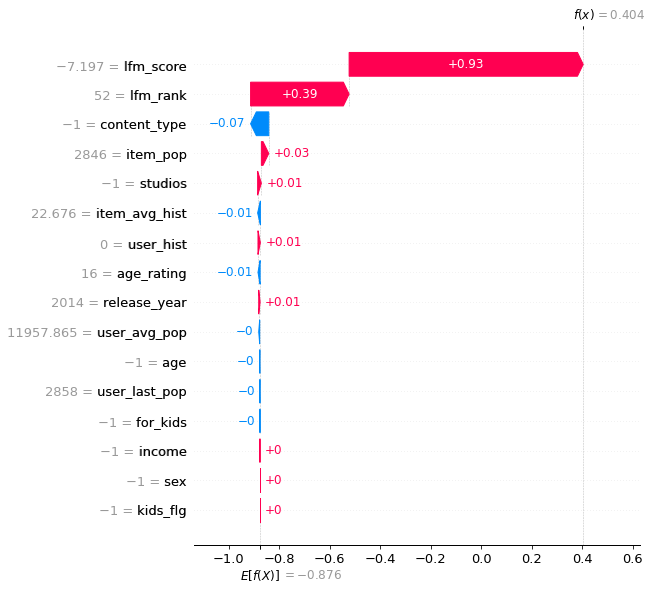

In [156]:
explainer = shap.Explainer(LGBMRanker_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap.plots.waterfall(shap_values[0], max_display=len(cols))

In [157]:
y_pred: np.ndarray = LGBMRanker_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, 'LGBMRanker')
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,als_score,als_rank,popular_score,...,age_rating,studios,genre,item_pop,item_avg_hist,target_ranker,LGBMRanker_score,LGBMRanker_rank,LGBMRanker_hybrid_score,LGBMRanker_hybrid_rank
0,1,3669.0,2021-08-16,1593.0,26.0,-7.196952,52.0,NaN,NaN,NaN,...,16.0,-1,NaN,2846.0,22.675978,1,0.376871,1,0.376871,1
1,1,10440.0,2021-08-13,19579.0,80.0,-7.196952,52.0,NaN,NaN,NaN,...,18.0,-1,"[триллеры, детективы]",141889.0,8.068716,2,0.368079,2,0.368079,2
2,12,846.0,2021-08-21,5929.0,18.0,-7.196952,52.0,NaN,NaN,NaN,...,16.0,-1,"[драмы, триллеры]",528.0,22.799242,1,0.384383,1,0.384383,1


In [158]:
models_metrics['LGBMRanker'] = calc_metrics_(ranker_test, 'LGBMRanker_rank')
models_metrics['LGBMRanker_hybrid'] = calc_metrics_(ranker_test, 'LGBMRanker_hybrid_rank')
pd.DataFrame(models_metrics)[['LGBMRanker', 'LGBMRanker_hybrid']]

,LGBMRanker,LGBMRanker_hybrid
recall@10,0.967554,0.967554
ndcg@10,0.444158,0.444158


### XGBRanker

In [159]:
def get_group_xgb(df: pd.DataFrame) -> np.ndarray:
    return np.array(df['user_id'].value_counts())

In [160]:
fit_params = {
    'X': ranker_train[cols].drop(cat_cols, axis=1),
    'y': ranker_train['target_ranker'],
    'group': get_group_xgb(ranker_train),
    'eval_set': [(ranker_val[cols].drop(cat_cols, axis=1), ranker_val['target_ranker'])],
    'eval_group': [get_group_xgb(ranker_val)],
    'eval_metric': 'ndcg',
    'verbose': early_stopping_rounds / 8,
}
params = {
    'objective': 'rank:ndcg',
    'n_estimators': 100,#00,
    'max_depth': 4,
    'num_leaves': 10,
    'min_child_samples': 100,
    'learning_rate': 0.25,
    'reg_lambda': 1,
    'colsample_bytree': 0.9,
    'random_state': 42,
}

In [161]:
XGBRanker_model = XGBRanker(**params)

In [162]:
%%time
XGBRanker_model.fit(**fit_params)

CPU times: user 25.2 s, sys: 32.7 ms, total: 25.3 s
Wall time: 27 s


XGBRanker(colsample_bytree=0.9, learning_rate=0.25, max_depth=4,
          min_child_samples=100, num_leaves=10, objective='rank:ndcg',
          random_state=42)

In [163]:
# save model  
with open(f'xgb_ranker_model.dill', 'wb') as f:
    dill.dump(XGBRanker_model, f)

In [167]:
y_pred: np.ndarray = XGBRanker_model.predict(ranker_test[cols].drop(cat_cols, axis=1))
ranker_test = add_score_and_rank(ranker_test, y_pred, 'XGBRanker')
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,als_score,als_rank,popular_score,...,item_avg_hist,target_ranker,LGBMRanker_score,LGBMRanker_rank,LGBMRanker_hybrid_score,LGBMRanker_hybrid_rank,XGBRanker_score,XGBRanker_rank,XGBRanker_hybrid_score,XGBRanker_hybrid_rank
0,1,3669.0,2021-08-16,1593.0,26.0,-7.196952,52.0,NaN,NaN,NaN,...,22.675978,1,0.376871,1,0.376871,1,2.847227,1,2.847227,1
1,1,10440.0,2021-08-13,19579.0,80.0,-7.196952,52.0,NaN,NaN,NaN,...,8.068716,2,0.368079,2,0.368079,2,1.242025,2,1.242025,2
2,12,846.0,2021-08-21,5929.0,18.0,-7.196952,52.0,NaN,NaN,NaN,...,22.799242,1,0.384383,1,0.384383,1,3.425755,1,3.425755,1


In [168]:
models_metrics['XGBRanker'] = calc_metrics_(ranker_test, 'XGBRanker_rank')
models_metrics['XGBRanker_hybrid'] = calc_metrics_(ranker_test, 'XGBRanker_hybrid_rank')
pd.DataFrame(models_metrics)[['XGBRanker', 'XGBRanker_hybrid']]

,XGBRanker,XGBRanker_hybrid
recall@10,0.967610,0.967610
ndcg@10,0.444156,0.444156


### CatBoostRanker

In [256]:
params = {
    'n_estimators': 100,#00,
    'depth': 4,
    'learning_rate': 0.25,
    'reg_lambda': 1, 
    'random_seed': 42,
    'early_stopping_rounds': early_stopping_rounds,
    'custom_metric': 'NDCG:top=10',
    'verbose': 1,
}

fit_params = {
    'X': Pool(data=ranker_train[cols],
              label=ranker_train['target_ranker'],
              group_id=ranker_train['user_id'].values,
              cat_features=cat_cols),          
    'eval_set': Pool(data=ranker_val[cols],
              label=ranker_val['target_ranker'],
              group_id=ranker_val['user_id'].values,
              cat_features=cat_cols),
    'early_stopping_rounds': early_stopping_rounds,
    'plot': 1,
    # 'cat_features': cat_cols,
    'verbose': 10,
}

In [257]:
%%time
CatBoostRanker_model = CatBoostRanker(**params)
CatBoostRanker_model.fit(**fit_params)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Groupwise loss function. OneHotMaxSize set to 10
0:	test: 0.6542969	best: 0.6542969 (0)	total: 1.08s	remaining: 1m 47s
10:	test: 0.7415079	best: 0.7415079 (10)	total: 12.6s	remaining: 1m 42s
20:	test: 0.7734205	best: 0.7734205 (20)	total: 23.1s	remaining: 1m 26s
30:	test: 0.7823964	best: 0.7823964 (30)	total: 33.5s	remaining: 1m 14s
40:	test: 0.7821225	best: 0.7824519 (34)	total: 43.8s	remaining: 1m 2s
50:	test: 0.7829241	best: 0.7850328 (43)	total: 54s	remaining: 51.9s
60:	test: 0.7852026	best: 0.7852026 (60)	total: 1m 4s	remaining: 41.1s
70:	test: 0.7856736	best: 0.7856742 (69)	total: 1m 16s	remaining: 31.4s
80:	test: 0.7874039	best: 0.7874039 (80)	total: 1m 27s	remaining: 20.5s
90:	test: 0.7859966	best: 0.7874039 (80)	total: 1m 37s	remaining: 9.65s
99:	test: 0.7864083	best: 0.7874039 (80)	total: 1m 48s	remaining: 0us

bestTest = 0.7874038716
bestIteration = 80

Shrink model to first 81 iterations.
CPU times: user 3min 14s, sys: 1.52 s, total: 3min 15s
Wall time: 1min 48s


In [258]:
# save model  
with open(f'CatBoostRanker_model.dill', 'wb') as f:
    dill.dump(CatBoostRanker_model, f)

In [262]:
y_pred: np.ndarray = CatBoostRanker_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, 'CatBoostRanker')
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,als_score,als_rank,popular_score,...,LGBMRanker_hybrid_score,LGBMRanker_hybrid_rank,XGBRanker_score,XGBRanker_rank,XGBRanker_hybrid_score,XGBRanker_hybrid_rank,CatBoostRanker_score,CatBoostRanker_rank,CatBoostRanker_hybrid_score,CatBoostRanker_hybrid_rank
0,1,3669.0,2021-08-16,1593.0,26.0,-7.196952,52.0,NaN,NaN,NaN,...,0.376871,1,2.847227,1,2.847227,1,3.521116,1,3.521116,1
1,1,10440.0,2021-08-13,19579.0,80.0,-7.196952,52.0,NaN,NaN,NaN,...,0.368079,2,1.242025,2,1.242025,2,2.660772,2,2.660772,2
2,12,846.0,2021-08-21,5929.0,18.0,-7.196952,52.0,NaN,NaN,NaN,...,0.384383,1,3.425755,1,3.425755,1,3.482842,1,3.482842,1


In [263]:
models_metrics['CatBoostRanker'] = calc_metrics_(ranker_test, 'CatBoostRanker_rank')
models_metrics['CatBoostRanker_hybrid'] = calc_metrics_(ranker_test, 'CatBoostRanker_hybrid_rank')
pd.DataFrame(models_metrics)[['CatBoostRanker', 'CatBoostRanker_hybrid']]

,CatBoostRanker,CatBoostRanker_hybrid
recall@10,0.967520,0.967520
ndcg@10,0.444141,0.444141


## Итоговые метрики

Time

LGBMRanker     - 7.77 s

XGBRanker      - 27 s

CatBoostRanker - 1min 48s

In [265]:
pd.DataFrame(models_metrics)[['LGBMRanker', 'XGBRanker', 'CatBoostRanker']]

,LGBMRanker,XGBRanker,CatBoostRanker
recall@10,0.967554,0.967610,0.967520
ndcg@10,0.444158,0.444156,0.444141


## Вывод:
LGBMRanker работает быстрее и имеет наибольшее знаенчие ndcg@10